In [1]:
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


print(tf.__version__)
print(np.__version__)

2.3.0
1.18.5


In [2]:
# divide uma série temporal univariada em amostras
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontra o final da amostra
        end_ix = i + n_steps
        # verifica se passou do final
        if end_ix > len(sequence)-1:
            break
        # junta as partes de entrada e saída do padrão
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [3]:
df = pd.read_csv('sp_beaches_update.csv', parse_dates=['Date'])
df = df.sort_values(by=['Date'])
df=df.loc[~df['Enterococcus'].isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69339 entries, 0 to 66738
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   City          69339 non-null  object        
 1   Beach         69339 non-null  object        
 2   Date          69339 non-null  datetime64[ns]
 3   Enterococcus  69339 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.6+ MB


In [4]:
cidade="UBATUBA"
praia="GRANDE"
 
df_beach = df.loc[df['City']==cidade].loc[df['Beach']==praia][['Date','Enterococcus']]
df_beach.columns = ['ds', 'y']
df_beach.set_index('ds', inplace=True)
df_beach

,y
ds,
2012-01-03,5
2012-01-08,42
2012-01-15,92
2012-01-22,16
2012-01-29,9
...,...
2020-10-05,31
2020-10-12,15
2020-10-19,3


In [5]:
# escolhe o número de pontos no tempo que serão utilizados para treinar e prever o próximo ponto da série
n_steps = 16
# divide a série temporal, em amostras
X, y = split_sequence(df_beach.values, n_steps)
X.shape

(418, 16, 1)

In [6]:
y.shape

(418, 1)

In [7]:
# reshape de [samples, timesteps] para [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(418, 16, 1)

In [8]:
# definir o modelo
model = Sequential()
model.add(LSTM(104, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(104, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [9]:
# treinar o modelo
with tf.device('/GPU:0'): 
    R = model.fit(X, y, epochs=200, verbose=1)
R

Epoch 1/200
14/14 [==============================] - 0s 13ms/step - loss: 814.0945
Epoch 2/200
14/14 [==============================] - 0s 12ms/step - loss: 716.1618
Epoch 3/200
14/14 [==============================] - 0s 13ms/step - loss: 708.0031
Epoch 4/200
14/14 [==============================] - 0s 12ms/step - loss: 699.1190
Epoch 5/200
14/14 [==============================] - 0s 12ms/step - loss: 675.4978
Epoch 6/200
14/14 [==============================] - 0s 12ms/step - loss: 654.4631
Epoch 7/200
14/14 [==============================] - 0s 12ms/step - loss: 662.9029
Epoch 8/200
14/14 [==============================] - 0s 12ms/step - loss: 662.4587
Epoch 9/200
14/14 [==============================] - 0s 12ms/step - loss: 704.6560
Epoch 10/200
14/14 [==============================] - 0s 12ms/step - loss: 681.7074
Epoch 11/200
14/14 [==============================] - 0s 12ms/step - loss: 656.3859
Epoch 12/200
14/14 [==============================] - 0s 12ms/step - loss: 628.4847
E

14/14 [==============================] - 0s 12ms/step - loss: 195.1058
Epoch 99/200
14/14 [==============================] - 0s 12ms/step - loss: 180.0485
Epoch 100/200
14/14 [==============================] - 0s 12ms/step - loss: 174.6844
Epoch 101/200
14/14 [==============================] - 0s 12ms/step - loss: 154.2025
Epoch 102/200
14/14 [==============================] - 0s 12ms/step - loss: 145.6660
Epoch 103/200
14/14 [==============================] - 0s 12ms/step - loss: 171.6100
Epoch 104/200
14/14 [==============================] - 0s 12ms/step - loss: 172.9984
Epoch 105/200
14/14 [==============================] - 0s 12ms/step - loss: 244.3321
Epoch 106/200
14/14 [==============================] - 0s 12ms/step - loss: 194.1090
Epoch 107/200
14/14 [==============================] - 0s 12ms/step - loss: 177.5036
Epoch 108/200
14/14 [==============================] - 0s 12ms/step - loss: 434.2696
Epoch 109/200
14/14 [==============================] - 0s 12ms/step - loss: 323.

Epoch 195/200
14/14 [==============================] - 0s 12ms/step - loss: 10.2035
Epoch 196/200
14/14 [==============================] - 0s 12ms/step - loss: 9.0875
Epoch 197/200
14/14 [==============================] - 0s 12ms/step - loss: 8.8384
Epoch 198/200
14/14 [==============================] - 0s 12ms/step - loss: 8.8019
Epoch 199/200
14/14 [==============================] - 0s 12ms/step - loss: 7.7916
Epoch 200/200
14/14 [==============================] - 0s 12ms/step - loss: 7.0649


In [10]:
round(R.history['loss'][-1])

7

In [11]:
yhat = model.predict(X, verbose=1)
print(y.shape)
print(yhat.shape)

14/14 [==============================] - 0s 4ms/step
(418, 1)
(418, 1)


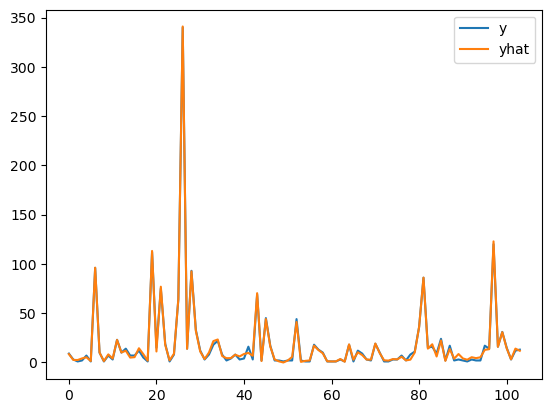

In [12]:
ultimos = 104
pd.DataFrame({'y':y[-ultimos:].reshape((ultimos)),'yhat':yhat[-ultimos:].reshape((ultimos))}).plot()
plt.show()

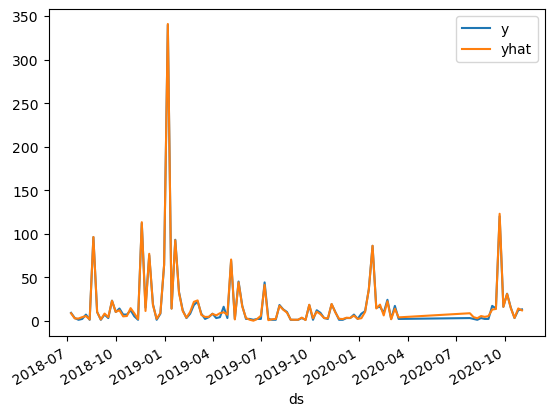

In [13]:
s1 = pd.DataFrame({'yhat':yhat.reshape((y.shape[0]))}, index=df_beach.index[-y.shape[0]:])
result = pd.concat([df_beach.iloc[-y.shape[0]:], s1], axis=1)
result.iloc[-104:].plot()
plt.show()